# 2020 Presidential Election Time Series
## Project Setup

In [9]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1285
docs/index.html commits: 570


,commit,datetime,vote_id,vote_total,request_id,request_total
1,e7a97da568c9aa0182fe6168d39fb81d4c8d3d02,2020-10-30 17:32:00-04:00,total-voted,86166713,mail-ballots-requested,90824844
3,3156c7da627311848695fe0519fa689f2400d4a3,2020-10-30 15:48:00-04:00,total-voted,85755756,mail-ballots-requested,90815681
5,a542ad227927afcdca78359390dfb62d22b27e81,2020-10-30 14:56:00-04:00,total-voted,85721762,mail-ballots-requested,90796702
7,8cf0ccba1ea9d3fc5764e1b5d3068e48e0afa321,2020-10-30 14:12:00-04:00,total-voted,85419780,mail-ballots-requested,90732048
8,ab64b5d7f73c9c63487900c265a0f3e4c70aea0b,2020-10-30 13:50:00-04:00,total-voted,85042877,mail-ballots-requested,90699752
...,...,...,...,...,...,...
565,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
566,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
567,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
568,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


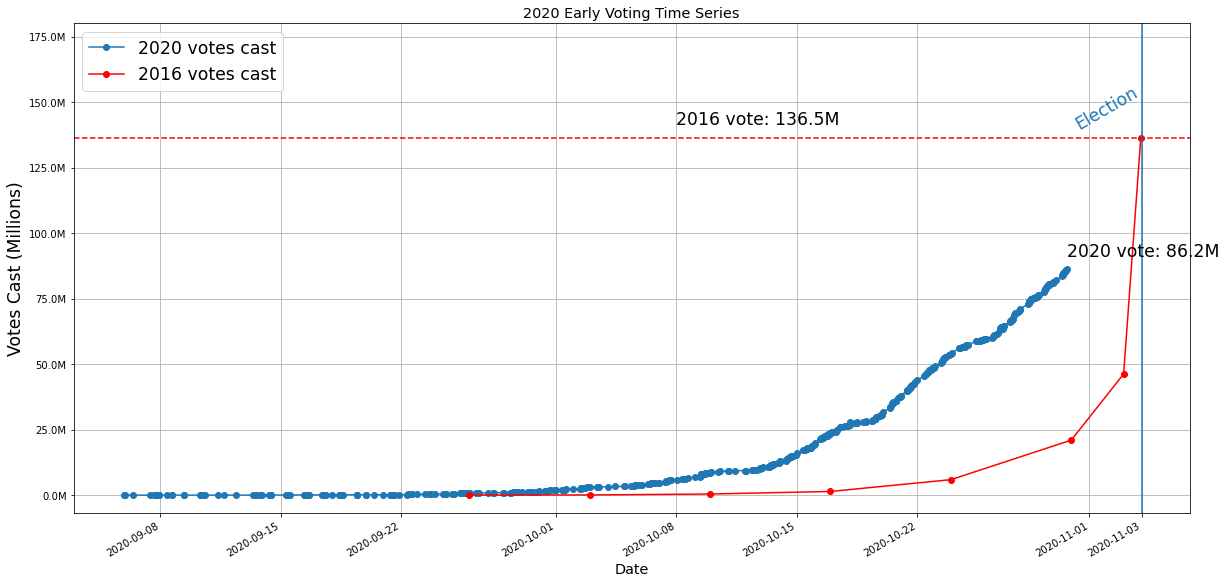

Loading BokehJS ...

In [10]:
update_notebook()

In [ ]:
# https://www.codegrepper.com/code-examples/python/run+a+function+every+hour+python
# from time import time, sleep
# from IPython.display import clear_output
# print('begin')
# while True:
#     clear_output()
#     sleep(1 - time() % 1)
    
#     print('clear')
# 	# thing to run

In [ ]:
# def countdown(t):
    
#     print('Updating data')
#     %run get_data.py
    
#     while t: 
#         mins, secs = divmod(t, 60) 
#         timer = '{:02d}:{:02d}'.format(mins, secs) 
#         print(timer, end="\r")
#         time.sleep(1) 
#         t -= 1
    
#     countdown(int(t))
    
# # input time in seconds 
# t = 3600 # input("Enter the time in seconds: ") 
  
# # function call 
# countdown(int(t)) 